In [1]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
import matplotlib.pyplot as plt
import random

In [2]:
class LinearRegression:

    def __init__(self,X,y,learningRate,maxIteration,error,epsilon,gd,stochastic_gd, regularization, ridge_lambda):
        self.w = None
        self.lowRank = None
        self.FullRank = None
        self.learningRate = learningRate
        self.X = X
        self.y = y
        self.maxIteration = maxIteration
        self.epsilon = epsilon
        self.gd = gd
        self.stochastic_gd = stochastic_gd
        self.regularization= regularization
        self.ridge_lambda = ridge_lambda
        self.error= error

    
    def splitData(self):
        X_Train, X_Test, y_Train, y_Test = train_test_split(self.X,self.y,test_size=0.3,random_state=0,shuffle=True)
        return X_Train, X_Test, y_Train, y_Test

    def add_X0(self,X):
        return np.column_stack((np.ones(X.shape[0]),X))

    def normalizeTrain(self,X_Train):
        mean = np.mean(X_Train, axis =0)
        std = np.std(X_Train, axis =0)
        X_norm = (X_Train - mean)/std
        X_norm = self.add_X0(X_norm)
        return X_norm,mean,std

    def normalizeTest(self,X_test,mean,std):
        X_norm = (X_test - mean)/std
        X_norm = self.add_X0(X_norm)
        return X_norm
    
    def rank(self,X_Train):
      # rank = np.linalg.matrix_rank(X)
        v,s,u = np.linalg.svd(X_Train)
        rank = np.sum([1 if abs(x) > 0 else 0 for x in s])
        return rank

    def checkFullRank(self,X_Train):
        rank  = self.rank(X_Train)
        if rank == min(X_Train.shape):
            self.FullRank = True
        else:
            self.FullRank = False

    def checkLowRank(self,X_Train):
        if X_Train.shape[1] < X_Train.shape[0]:
            self.lowRank = False
        else:
            self.lowRank = True

    def normalEquation(self,X_Train,y_Train):
        return np.linalg.inv(X_Train.T.dot(X_Train)).dot(X_Train.T).dot(y_Train)

    def predict(self,X_test_data_point):
        return X_test_data_point.dot(self.w)

    def sse(self,X,y): ## Sum Square Errors
        y_hat =self.predict(X)
        return((y-y_hat)**2).sum()

    def costFunction(self,X,y):
        return self.sse(X,y)/2

    def costDerivative(self,X_Train,y_Train):
        y_hat = self.predict(X_Train)
        return (y_hat - y_Train).dot(X_Train)

    def gradientDescent(self,X_Train,y_Train):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
            gradient = self.costDerivative(X_Train,y_Train)
            self.w = self.w - (self.learningRate * gradient)
            current_error = self.costFunction(X_Train,y_Train)
            error_diff= error_prev - current_error
            error_prev = current_error
            errors.append(current_error)
            if  abs(error_diff) < self.epsilon:
                print('Model stopped running')
                break
            
        self.plot_rmse(errors)
        
        return
        
    ## NORMAL EQUATION WITH REGULARIZATION
    def normalEquationWithRegularization(self,X_Train,y_Train):
        identity_matrix = self.ridge_lambda*np.identity(n=X_Train.shape[1], dtype = np.float32)
        return np.linalg.inv(X_Train.T.dot(X_Train) + identity_matrix).dot(X_Train.T).dot(y_Train)
    
    ## COST FUNCTION WITH REGULARIZATION (USED FOR GRADIENT DESCENT)
    def costFunctionWithRegularization(self,X,y):
        return self.sse(X,y)/2 + (self.ridge_lambda*np.sum(self.w**2))/2

    ## COST FUNCTION DERIVATIVE WITH REGULARIZATION (USED FOR GRADIENT DESCENT)
    def costDerivativeWithRegularization(self,X,y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X) + self.ridge_lambda*self.w

    ## GRADIENT DESCENT WITH REGULARIZATION
    def gradientWithRegularization(self,X_Train,y_Train):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
            gradient = self.costDerivativeWithRegularization(X_Train,y_Train)
            self.w = self.w - (self.learningRate * gradient)
            current_error = self.costFunctionWithRegularization(X_Train,y_Train)
            error_diff= error_prev - current_error
            error_prev = current_error
            errors.append(current_error)
            if np.abs(error_diff) < self.epsilon:
                print('Model stopped running')
                break
        self.plot_rmse(errors)
    
    ## STOCHASTIC GRADIENT DESCENT
    def stochasticGradientDescent(self, X_Train, y_Train):
        errors = []
        error_prev = np.inf

        for t in tqdm(range(self.maxIteration)):
            X_Gradient_Sample, _, y_Gradient_Sample ,__  = train_test_split(X_Train,y_Train,test_size=0.80,shuffle=True)
            gradient = self.costDerivative(X_Gradient_Sample,y_Gradient_Sample)
            self.w = self.w - (self.learningRate * gradient)
            current_error = self.costFunction(X_Gradient_Sample,y_Gradient_Sample)
            error_diff= error_prev - current_error
            error_prev = current_error
            errors.append(current_error)
            if  abs(error_diff) < self.epsilon:
                print('Model stopped running')
                break
        self.plot_rmse(errors)

    ## STOCHASTIC GRADIENT DESCENT WITH REGULARIZATION
    def stochasticGradientWithRegularization(self,X_Train,y_Train):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
            X_Gradient_Sample, _, y_Gradient_Sample ,__  = train_test_split(X_Train,y_Train,test_size=0.80,shuffle=True)
            gradient = self.costDerivativeWithRegularization(X_Gradient_Sample,y_Gradient_Sample)
            self.w = self.w - (self.learningRate * gradient)
            current_error = self.costFunctionWithRegularization(X_Gradient_Sample,y_Gradient_Sample)
            error_diff= error_prev - current_error
            error_prev = current_error
            errors.append(current_error)
            if np.abs(error_diff) < self.epsilon:
                print('Model stopped running')
                break
        self.plot_rmse(errors)

    # Function for RMSE error calculation        
    def rmse(self, X, y):
        return np.sqrt(self.sse(X, y) / X.shape[0])
        
    def plot_rmse(self, errors):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(errors)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel=self.error,
               title='{} trend'.format(self.error))
        ax.grid()

        #plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()
        
    def fit(self):
        X_train,X_test,y_train,y_test = self.splitData()
        X_train, mean,std = self.normalizeTrain(X_train)
        X_test = self.normalizeTest(X_test,mean,std)
        
        ## IF REGULARIZATION IS TRUE AND WE ARE EXPECTED TO SOLVE USING NORMAL EQUATION THEN WE NEED TO CHECK IF X_train.T.dot(X_train) + lambda*I IS INVERTIBLE OR NOT
        if self.regularization and not self.gd and not self.stochastic_gd:
          checkInvertible = (X_train.T.dot(X_train)) + (self.ridge_lambda*np.identity(n=X_train.shape[1], dtype = np.float32))
          self.checkFullRank(checkInvertible)
          self.checkLowRank(X_train)
        else:
          self.checkFullRank(X_train)
          self.checkLowRank(X_train)

        ## ADDED OUTPUT MESSAGES TO BE PRINTED IF USER TRIES TO USE NORMAL EQUATION FOR NON INVERTIBLE MATRIX OR LARGE DATASET
        if (not self.FullRank or self.lowRank) and not self.gd and not self.stochastic_gd:
          print('The dataset is not Full Rank. Cannot use normal equaltion to train this model. Try using Stochastic Gradient Descent or Gradient Descent')
          return

        if X_train.shape[0] > 10000 and not self.gd and not self.stochastic_gd:
          print('The dataset size if large. Using normal Equation to train this model would be time expensinve. Try using Stochastic Gradient Descent or Gradient Descent')
          return


        ## FOLLOWING IF ELSE LADDER CONTROLS WHICH METHOD WILL BE USED TO SOLVE LINEAR REGRESSION, BASED ON USER INPUT
        if (self.FullRank and not self.lowRank and X_train.shape[0] <= 10000 and not self.gd and not self.stochastic_gd and 
        not self.regularization):
            print('Solved using normal equation without regularization')
            self.w = self.normalEquation(X_train,y_train)

        if (self.FullRank and not self.lowRank and X_train.shape[0] <= 10000 and not self.gd and not self.stochastic_gd and
        self.regularization):
            print('Solved using normal equation with regularization')
            self.w = self.normalEquationWithRegularization(X_train,y_train)    
            
        elif self.gd and not self.regularization:
            print('Solved using gradient descent without regularization')
            self.w = np.zeros(X_train.shape[1])
            self.gradientDescent(X_train,y_train)

        elif self.gd and self.regularization:
            print('Solved using gradient descent with regularization')
            self.w = np.zeros(X_train.shape[1])
            self.gradientWithRegularization(X_train,y_train)
            
        elif self.stochastic_gd and not self.regularization:
            print('Solved using stochastic gradient descent without regularization')
            self.w = np.zeros(X_train.shape[1])
            self.stochasticGradientDescent(X_train,y_train)
            
        elif self.stochastic_gd and self.regularization:
            print('Solved using stochastic gradient descent with regularization')
            self.w = np.zeros(X_train.shape[1])
            self.stochasticGradientWithRegularization(X_train,y_train)
           
        
        print(self.w)
        print('RMSE FOR TRAIN: ' + str(self.rmse(X_train,y_train)))
        print('RMSE FOR TEST: ' + str(self.rmse(X_test,y_test)))
        print('SSE FOR TRAIN: ' + str(self.sse(X_train, y_train)))
        print('SSE FOR TEST: ' + str(self.sse(X_test, y_test)))

    

# HOUSING DATA

In [3]:
df = pd.read_csv('housing.csv',header=None,names=['A','B','C','D','E','F','G','H','I','J','K','L','M','N'])
df.shape

(506, 14)

In [4]:
df.N.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: N, dtype: float64

In [5]:
X = df.values[:,0:-1]
y = df.values[:,-1]

## USING NORMAL EQUATION WITHOUT REGULARIZATION

In [6]:
clf = LinearRegression(X,y,0.0004,50000,error= 'rmse', epsilon=0.005,gd=False,stochastic_gd=False,regularization=False, ridge_lambda=0.001)
clf.fit()

Solved using normal equation without regularization
[22.74548023 -1.01189299  1.05028731  0.07922238  0.61896311 -1.87367112
  2.70526765 -0.27955798 -3.09763515  2.09690865 -1.88608488 -2.26109811
  0.58264435 -3.44050512]
RMSE FOR TRAIN: 4.467466666510133
RMSE FOR TEST: 5.214973224911791
SSE FOR TRAIN: 7065.2234793982225
SSE FOR TEST: 4133.783751955127


## USING GRADIENT DESCENT WITHOUT REGULARIZATION

Solved using gradient descent without regularization


  1%|          | 325/50000 [00:00<00:04, 11928.36it/s]

Model stopped running


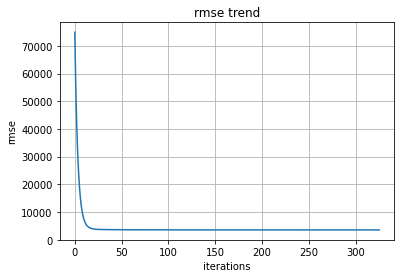

[22.74548023 -1.0049243   1.03819316  0.03918717  0.62473779 -1.86196032
  2.7131382  -0.28829151 -3.09893896  1.99727284 -1.77426616 -2.25659407
  0.5806868  -3.43728429]
RMSE FOR TRAIN: 4.467639454262914
RMSE FOR TEST: 5.219112104874148
SSE FOR TRAIN: 7065.770011823464
SSE FOR TEST: 4140.347936813067


In [7]:
clf = LinearRegression(X,y,0.0004,50000,error='rmse', epsilon=0.005,gd=True,stochastic_gd=False,regularization=False, ridge_lambda=0.001)
clf.fit()

## USING STOCHASTIC GRADIENT DESCENT WITHOUT REGULARIZATION

Solved using stochastic gradient descent without regularization


 25%|██▌       | 12554/50000 [00:02<00:06, 5429.98it/s]


Model stopped running


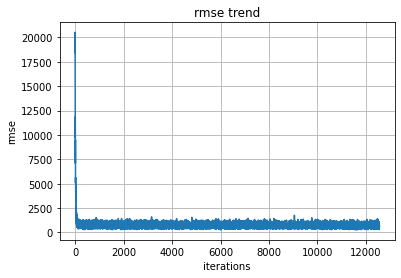

[22.60171672 -0.98625534  1.08969957  0.06022675  0.4591499  -1.99428033
  2.71588304 -0.2322611  -3.11792526  2.0017384  -1.91467759 -2.21828985
  0.49764762 -3.26788958]
RMSE FOR TRAIN: 4.477694341600782
RMSE FOR TEST: 5.256416274155783
SSE FOR TRAIN: 7097.610302348496
SSE FOR TEST: 4199.746631175884


In [8]:
clf = LinearRegression(X,y,0.0004,50000,error='rmse', epsilon=0.005,gd=False,stochastic_gd=True,regularization=False, ridge_lambda=200)
clf.fit()

## USING NORMAL EQUATION WITH REGULARIZATION

In [17]:
clf = LinearRegression(X,y,0.0004,5000,error= 'rmse', epsilon=0.005,gd=False,stochastic_gd=False,regularization=True, ridge_lambda=40)
clf.fit()

Solved using normal equation with regularization
[20.43629442 -0.81601561  0.69403944 -0.34721997  0.68363057 -1.04754131
  2.81980805 -0.33777338 -2.07888604  0.74578352 -0.79387682 -2.03361886
  0.59364614 -2.98886261]
RMSE FOR TRAIN: 5.101876467608425
RMSE FOR TEST: 5.903280470421898
SSE FOR TRAIN: 9214.316795720762
SSE FOR TEST: 5297.005487494617


## USING GRADIENT DESCENT WITH REGULARIZATION

Solved using gradient descent with regularization


  0%|          | 119/50000 [00:00<00:02, 17592.69it/s]

Model stopped running


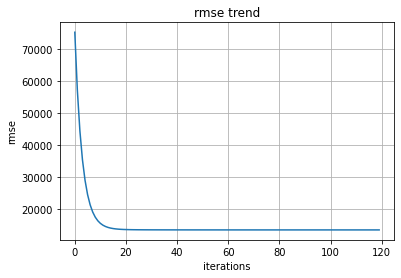

[20.43629439 -0.81266143  0.68736497 -0.35902635  0.68559899 -1.03505989
  2.82502295 -0.34139736 -2.07044565  0.712548   -0.76045807 -2.03136152
  0.5937129  -2.98654927]
RMSE FOR TRAIN: 5.103653344152873
RMSE FOR TEST: 5.905627964021699
SSE FOR TRAIN: 9220.736219878112
SSE FOR TEST: 5301.219130714132


In [18]:
clf = LinearRegression(X,y,0.0004,50000,error='rmse', epsilon=0.005,gd=True,stochastic_gd=False,regularization=True, ridge_lambda=40)
clf.fit()

## USING STOCHASTIC GRADIENT DESCENT WITH REGULARIZATION

Solved using stochastic gradient descent with regularization


100%|██████████| 50000/50000 [00:10<00:00, 4606.47it/s]


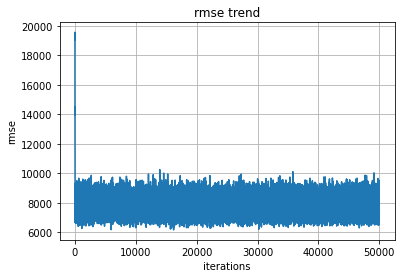

[14.41092731 -0.60989322  0.51827441 -0.40296818  0.56826812 -0.50242727
  2.18515097 -0.25929702 -0.80293991  0.04533306 -0.4562505  -1.47203689
  0.70721495 -2.14134907]
RMSE FOR TRAIN: 9.760967175166808
RMSE FOR TEST: 10.110149276477214
SSE FOR TRAIN: 33727.8739889181
SSE FOR TEST: 15536.697995683215


In [19]:
clf = LinearRegression(X,y,0.0004,50000,error='rmse', epsilon=0.005,gd=False,stochastic_gd=True,regularization=True, ridge_lambda=40)
clf.fit()

# CONCRETE DATA

In [20]:
df1 = pd.read_csv('concreteData.csv',header=None,names=['A','B','C','D','E','F','G','H','I'])
df1.shape

(1030, 9)

In [21]:
df1.I.describe()

count    1030.000000
mean       35.817961
std        16.705742
min         2.330000
25%        23.710000
50%        34.445000
75%        46.135000
max        82.600000
Name: I, dtype: float64

In [22]:
X = df1.values[:,0:-1]
y = df1.values[:,-1]

## USING NORMAL EQUATION WITHOUT REGULARIZATION

In [23]:
clf1 = LinearRegression(X,y,0.0007,5000,error= 'rmse', epsilon=0.0001,gd=False,stochastic_gd=False,regularization=False, ridge_lambda=0.001)
clf1.fit()

Solved using normal equation without regularization
[35.85368932 12.72547471  9.54463305  5.99752761 -2.82130272  2.10540297
  1.85195151  1.95023318  7.17433735]
RMSE FOR TRAIN: 10.64860379952002
RMSE FOR TEST: 9.67567754660951
SSE FOR TRAIN: 81756.18203586874
SSE FOR TEST: 28928.189419662704


## USING GRADIENT DESCENT WITHOUT REGULARIZATION

Solved using gradient descent without regularization


  1%|          | 418/50000 [00:00<00:02, 24592.43it/s]

Model stopped running


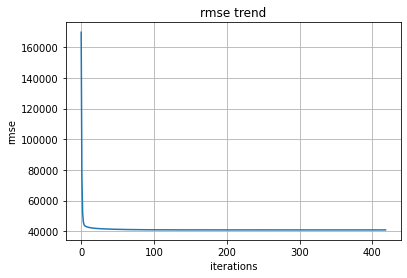

[35.85368932 12.71818519  9.53732026  5.9910877  -2.8275422   2.10453997
  1.84619169  1.94309972  7.17414238]
RMSE FOR TRAIN: 10.648604198134784
RMSE FOR TEST: 9.675518604088847
SSE FOR TRAIN: 81756.18815671283
SSE FOR TEST: 28927.239019743443


In [24]:
clf1 = LinearRegression(X,y,0.0007,50000,error='rmse', epsilon=0.0001,gd=True,stochastic_gd=False,regularization=False, ridge_lambda=0.001)
clf1.fit()

## USING STOCHASTIC GRADIENT DESCENT WITHOUT REGULARIZATION

Solved using stochastic gradient descent without regularization


100%|██████████| 50000/50000 [00:11<00:00, 4543.72it/s]


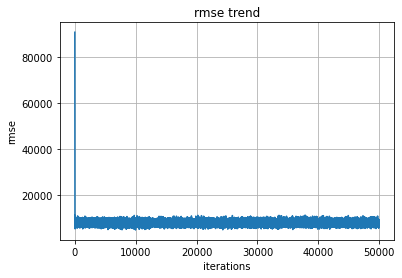

[35.58657831 12.67651554  9.43228577  6.56044034 -3.01421743  1.79857352
  1.76107448  2.03871832  6.74846117]
RMSE FOR TRAIN: 10.68231802607895
RMSE FOR TEST: 9.792503493964569
SSE FOR TRAIN: 82274.69317382001
SSE FOR TEST: 29630.97552590626


In [25]:
clf1 = LinearRegression(X,y,0.0007,50000,error='rmse', epsilon=0.0001,gd=False,stochastic_gd=True,regularization=False, ridge_lambda=10)
clf1.fit()

## USING NORMAL EQUATION WITH REGULARIZATION

In [28]:
clf1 = LinearRegression(X,y,0.0007,50000,error= 'rmse', epsilon=0.0001,gd=False,stochastic_gd=False,regularization=True, ridge_lambda=150)
clf1.fit()

Solved using normal equation with regularization
[29.67911596  6.30076299  3.31613588  0.4583879  -4.38690433  3.03045237
 -1.18388416 -2.10817459  5.48130471]
RMSE FOR TRAIN: 12.734049752530996
RMSE FOR TEST: 12.127540758084928
SSE FOR TRAIN: 116914.49265505295
SSE FOR TEST: 45446.868655254446


## USING GRADIENT DESCENT WITH REGULARIZATION

Solved using gradient descent with regularization


  0%|          | 52/50000 [00:00<00:03, 12943.85it/s]

Model stopped running


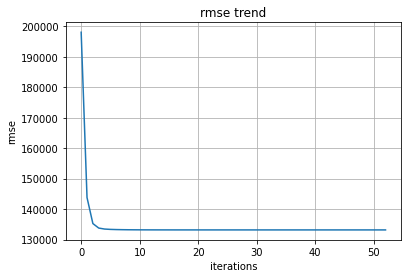

[29.67911596  6.29995016  3.31532044  0.45766559 -4.38758037  3.03037497
 -1.18451526 -2.10896281  5.48128132]
RMSE FOR TRAIN: 12.734101135638767
RMSE FOR TEST: 12.127554671677824
SSE FOR TRAIN: 116915.43617925978
SSE FOR TEST: 45446.9729351912


In [29]:
clf1 = LinearRegression(X,y,0.0007,50000,error='rmse', epsilon=0.0001,gd=True,stochastic_gd=False,regularization=True, ridge_lambda=150)
clf1.fit()

## USING STOCHASTIC GRADIENT DESCENT WITH REGULARIZATION

Solved using stochastic gradient descent with regularization


100%|██████████| 50000/50000 [00:11<00:00, 4301.64it/s]


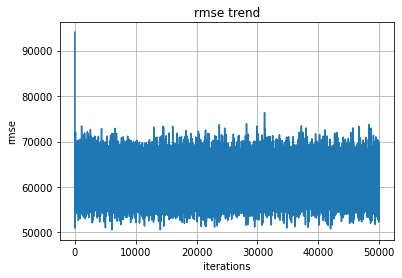

[17.55584085  3.31382198  1.08576879  0.10913089 -1.88485142  2.15863184
 -0.94061946 -1.71286862  3.07231753]
RMSE FOR TRAIN: 22.473837666724584
RMSE FOR TEST: 22.006306361163873
SSE FOR TRAIN: 364157.90659807815
SSE FOR TEST: 149641.7535753731


In [30]:
clf = LinearRegression(X,y,0.0007,50000,error='rmse', epsilon=0.0001,gd=False,stochastic_gd=True,regularization=True, ridge_lambda=150)
clf.fit()

# YACHT DATA

In [31]:
df2 = pd.read_csv('yachtData.csv',header=None,names=['A','B','C','D','E','F','G'])
df2.shape

(308, 7)

In [32]:
df2.G.describe()

count    308.000000
mean      10.495357
std       15.160490
min        0.010000
25%        0.777500
50%        3.065000
75%       12.815000
max       62.420000
Name: G, dtype: float64

In [33]:
X = df2.values[:,0:-1]
y = df2.values[:,-1]

## USING NORMAL EQUATION WITHOUT REGULARIZATION

In [34]:
clf2 = LinearRegression(X,y,0.001,50000,error= 'rmse', epsilon=0.001,gd=False,stochastic_gd=False,regularization=False, ridge_lambda=0.001)
clf2.fit()

Solved using normal equation without regularization
[11.23939535  0.81790302  0.20369276  2.97602416 -2.75890138 -3.83325201
 12.9328097 ]
RMSE FOR TRAIN: 9.012054802825176
RMSE FOR TEST: 8.80194763079057
SSE FOR TRAIN: 17461.68333036173
SSE FOR TEST: 7205.108234851716


## USING GRADIENT DESCENT WITHOUT REGULARIZATION

Solved using gradient descent without regularization


  3%|▎         | 1411/50000 [00:00<00:01, 39865.30it/s]

Model stopped running


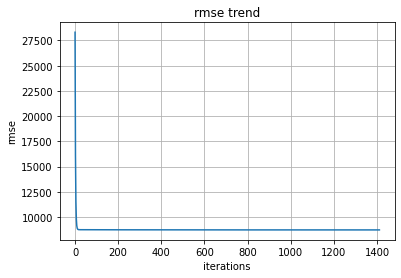

[11.23939535  0.81411017  0.10089999  2.56682738 -2.42492656 -3.43736949
 12.93251924]
RMSE FOR TRAIN: 9.012226843337482
RMSE FOR TEST: 8.793953646648665
SSE FOR TRAIN: 17462.350025291125
SSE FOR TEST: 7192.0267287647


In [35]:
clf2 = LinearRegression(X,y,0.001,50000,error='rmse', epsilon=0.001,gd=True,stochastic_gd=False,regularization=False, ridge_lambda=0.001)
clf2.fit()

## USING STOCHASTIC GRADIENT DESCENT WITHOUT REGULARIZATION

Solved using stochastic gradient descent without regularization


100%|██████████| 50000/50000 [00:09<00:00, 5365.83it/s]


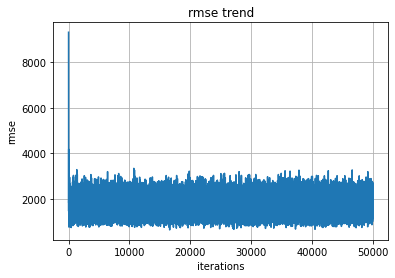

[11.40928993  0.65981589  0.14046553  2.82571513 -2.92362306 -3.86970032
 12.90379113]
RMSE FOR TRAIN: 9.019682151104396
RMSE FOR TEST: 8.863198200289323
SSE FOR TRAIN: 17491.25321299451
SSE FOR TEST: 7305.734257397907


In [36]:
clf2 = LinearRegression(X,y,0.001,50000,error='rmse', epsilon=0.001,gd=False,stochastic_gd=True,regularization=False, ridge_lambda=10)
clf2.fit()

## USING NORMAL EQUATION WITH REGULARIZATION

In [41]:
clf2 = LinearRegression(X,y,0.001,50000,error= 'rmse', epsilon=0.001,gd=False,stochastic_gd=False,regularization=True, ridge_lambda=250)
clf2.fit()

Solved using normal equation with regularization
[ 5.19670968  0.46671432 -0.32122345 -0.33055234 -0.09398695 -0.39220606
  5.98843953]
RMSE FOR TRAIN: 12.910114852207474
RMSE FOR TEST: 10.400658777425008
SSE FOR TRAIN: 35834.27908189542
SSE FOR TEST: 10060.154379411792


## USING GRADIENT DESCENT WITH REGULARIZATION

Solved using gradient descent with regularization


  0%|          | 13/50000 [00:00<00:07, 6628.49it/s]

Model stopped running


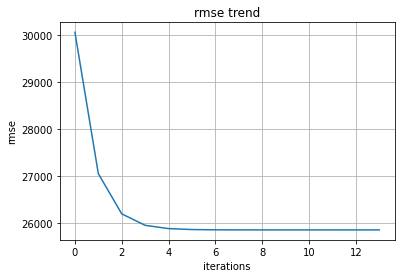

[ 5.19589181  0.46680617 -0.32128233 -0.33096849 -0.09376199 -0.39188316
  5.98748852]
RMSE FOR TRAIN: 12.911005993354395
RMSE FOR TEST: 10.401376917205424
SSE FOR TRAIN: 35839.22628849312
SSE FOR TEST: 10061.543684960963


In [42]:
clf2 = LinearRegression(X,y,0.001,50000,error='rmse', epsilon=0.001,gd=True,stochastic_gd=False,regularization=True, ridge_lambda=250)
clf2.fit()

## USING STOCHASTIC GRADIENT DESCENT WITH REGULARIZATION

Solved using stochastic gradient descent with regularization


100%|██████████| 50000/50000 [00:09<00:00, 5041.85it/s]


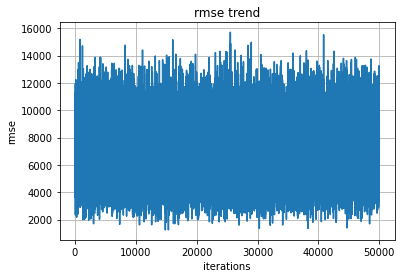

[ 1.84957824  0.3494594   0.10026685 -0.29053001 -0.19173766 -0.13048839
  2.17263612]
RMSE FOR TRAIN: 16.94424422118329
RMSE FOR TEST: 13.631935762760701
SSE FOR TRAIN: 61728.093628827206
SSE FOR TEST: 17282.15955552318


In [43]:
clf2 = LinearRegression(X,y,0.001,50000,error='rmse', epsilon=0.001,gd=False,stochastic_gd=True,regularization=True, ridge_lambda=250)
clf2.fit()

OBSERVATIONS:

1) The first theta term is the intercept and that is why it may have a high value. In other words, high value for first theta does not indicate overfitting.

2) For Normal Equation, Gradient Descent and Stochastic Gradient Descent , the Theta value decreases when regularisation is used.

3) There is an increase in the RMSE value when we increase the ridge lambda while doing regularization for Normal Equation, Gradient Descent and Stochastic Gradient Descent. Which is expected as regularization avoids overfitting.

4) It was observed that accross multiple runs stochastic graient descent rarely converges. Almost all the time, the number of iterations reaches the maximum number of iteration. This is because the dataset size is small, hence gradient descent outperforms stochastic gradient descent.
